In this notebook I will be trying to build GPI into HCIPy. 

This notebook was the basis for creating the functions in hcipy_gpi. It could be that hcipy_gpi is more up to date than this

In [80]:
import numpy as np
import matplotlib.pyplot as plt

from hcipy import *


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


## This function will be based off make_magellan_aperture that was provided with hcipy

In [51]:
def make_geminisouth_aperture(normalized=False, with_spiders=True):
    '''Make the Gemini South aperture.

    Parameters
    ----------
    normalized : boolean
        If this is True, the outer diameter will be scaled to 1. Otherwise, the
        diameter of the pupil will be 6.5 meters.
    with_spiders: boolean
        If this is False, the spiders will be left out.

    Returns
    -------
    Field generator
    The Gemini South aperture.
    '''
    pupil_diameter = 7.701 #m
    spider_widths = np.array([0.014,0.01,0.01,0.01])
    support_angles = [90-43.10, 90+43.10, 270-43.10, 270+43.10]
    central_obscuration_ratio = 1.2968/pupil_diameter #From gpipsfs the secondary is 1.2968
    support_offset_y = [0.2179, -0.2179,  -0.2179,   0.2179]

    spider_offset = [0,0.34] #m

    if normalized:
        spider_widths /= pupil_diameter
        support_offset_y = [x / pupil_diameter for x in support_offset_y]
        pupil_diameter = 1.0

    obstructed_aperture = make_obstructed_circular_aperture(pupil_diameter, central_obscuration_ratio)

    if not with_spiders:
        return obstructed_aperture

#     spider1 = make_spider_infinite([0,support_offset_y[0]], support_angles[0], spider_widths[0])
#     spider2 = make_spider_infinite([0,support_offset_y[1]], support_angles[1], spider_widths[1])
#     spider3 = make_spider_infinite([0,support_offset_y[2]], support_angles[2], spider_widths[2])
#     spider4 = make_spider_infinite([0,support_offset_y[3]], support_angles[3], spider_widths[3])   

    spider1 = make_spider_infinite([support_offset_y[0],0], support_angles[0], spider_widths[0])
    spider2 = make_spider_infinite([support_offset_y[1],0], support_angles[1], spider_widths[1])
    spider3 = make_spider_infinite([support_offset_y[2],0], support_angles[2], spider_widths[2])
    spider4 = make_spider_infinite([support_offset_y[3],0], support_angles[3], spider_widths[3])   

    def func(grid):
        output = obstructed_aperture(grid) * spider1(grid) * spider2(grid) * spider3(grid) * spider4(grid)
        return output.T
    return func

def make_gpi_lyot(normalized=False, with_spiders=True):
    '''Make the GPI H-band lyot mask
    '080m12_04'

    Parameters
    ----------
    normalized : boolean
        If this is True, the outer diameter will be scaled to 1. Otherwise, the
        diameter of the pupil will be 6.5 meters.
    with_spiders: boolean
        If this is False, the spiders will be left out.

    Returns
    -------
    Field generator
    The GPI H-band lyot mask
    '''
    
    #Many of the quantities below are defined in GPIPSFs in mm and then projected on the the primary. 
    primary_diameter = 7.7701
    magnification = primary_diameter/.009825   # meters at primary/meters at Lyot
    
    pupil_diameter = 2*4.786*1e-3*magnification
    central_obscuration_ratio = 1.388/4.786
    spider_widths = np.array([0.404*1e-3*magnification for x in range(4)])
    support_angles = [90-43.10, 90+43.10, 270-43.10, 270+43.10]
#     central_obscuration_ratio = 1.2968/pupil_diameter #From gpipsfs the secondary is 1.2968
    support_offset_y = [0.2179, -0.2179,  -0.2179,   0.2179]

    spider_offset = [0,0.34] #m

    if normalized:
        #When normalizing here, we want to normalize by the primary diameter
        spider_widths /= primary_diameter
        support_offset_y = [x / primary_diameter for x in support_offset_y]
        pupil_diameter /= primary_diameter

    obstructed_aperture = make_obstructed_circular_aperture(pupil_diameter, central_obscuration_ratio)

    if not with_spiders:
        return obstructed_aperture

#     spider1 = make_spider_infinite([0,support_offset_y[0]], support_angles[0], spider_widths[0])
#     spider2 = make_spider_infinite([0,support_offset_y[1]], support_angles[1], spider_widths[1])
#     spider3 = make_spider_infinite([0,support_offset_y[2]], support_angles[2], spider_widths[2])
#     spider4 = make_spider_infinite([0,support_offset_y[3]], support_angles[3], spider_widths[3])   

    spider1 = make_spider_infinite([support_offset_y[0],0], support_angles[0], spider_widths[0])
    spider2 = make_spider_infinite([support_offset_y[1],0], support_angles[1], spider_widths[1])
    spider3 = make_spider_infinite([support_offset_y[2],0], support_angles[2], spider_widths[2])
    spider4 = make_spider_infinite([support_offset_y[3],0], support_angles[3], spider_widths[3])   

#     spider2 = make_spider(spider_offset, mirror_edge2, spider_width1)
#     spider3 = make_spider(-spider_offset, mirror_edge3, spider_width2)
#     spider4 = make_spider(-spider_offset, mirror_edge4, spider_width2)

    def func(grid):
        return obstructed_aperture(grid) * spider1(grid) * spider2(grid) * spider3(grid) * spider4(grid)
    return func



In [52]:
pupil_grid=make_pupil_grid(1024)

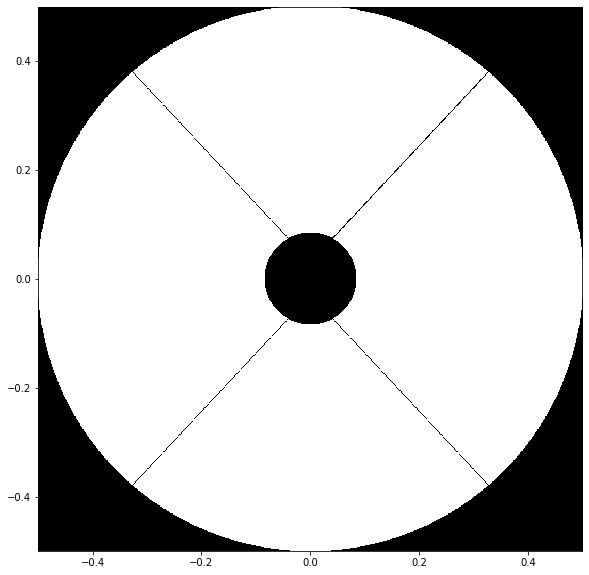

In [53]:
telescope_pupil_generator=make_geminisouth_aperture(normalized=True,with_spiders=True)
telescope_pupil = telescope_pupil_generator(pupil_grid)

plt.figure(figsize=(10,10))
im = imshow_field(telescope_pupil,cmap='gray')

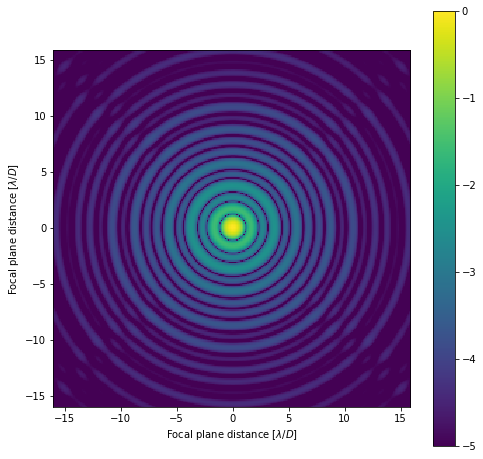

In [54]:
wavefront = Wavefront(telescope_pupil)

focal_grid = make_focal_grid(q=8,num_airy=16)
prop = FraunhoferPropagator(pupil_grid,focal_grid)

focal_image = prop.forward(wavefront)

fig = plt.figure(figsize=(8,8))
imshow_field(np.log10(focal_image.intensity / focal_image.intensity.max()), vmin=-5)
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.colorbar()
plt.show()

## For now we'll skip the apodizer and instead jump to the coronagraph

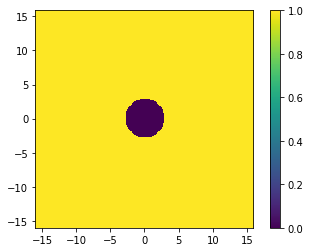

In [55]:
#The focal plane mask
fpm = 1-circular_aperture(5.65)(focal_grid) #Put in the the units in lambda/D
imshow_field(fpm)
plt.colorbar()

In [56]:
coro = LyotCoronagraph(pupil_grid,fpm)(wavefront)

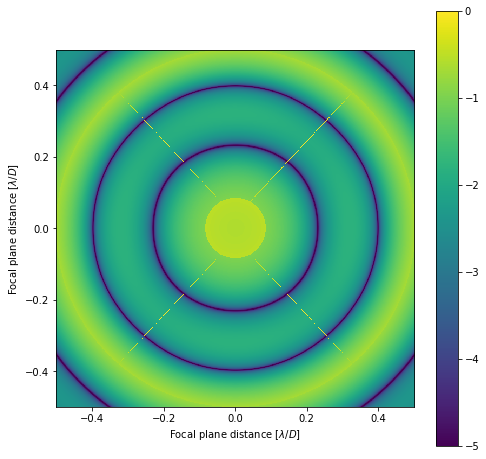

In [57]:
fig = plt.figure(figsize=(8,8))
imshow_field(np.log10(coro.intensity / coro.intensity.max()), vmin=-5)
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.colorbar()
plt.show()

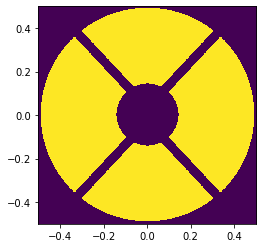

In [58]:
#The lyot stop
lyot_stop = make_gpi_lyot(normalized=True)(pupil_grid)
imshow_field(lyot_stop)

In [59]:
post_coro = LyotCoronagraph(pupil_grid,fpm,lyot_stop)(wavefront)

/Users/maxwellmb/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


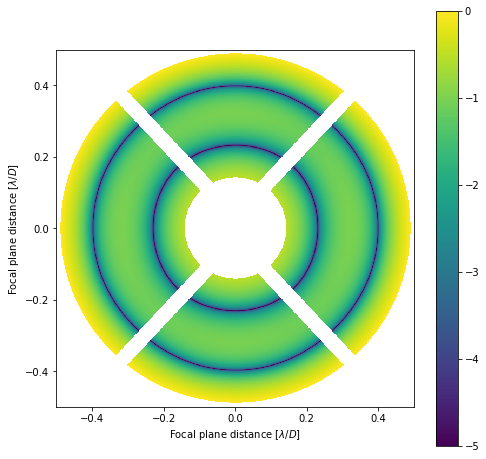

In [60]:
fig = plt.figure(figsize=(8,8))
imshow_field(np.log10(post_coro.intensity / post_coro.intensity.max()), vmin=-5)
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.colorbar()
plt.show()

## Now to the focal plane

In [61]:
img = prop(post_coro)

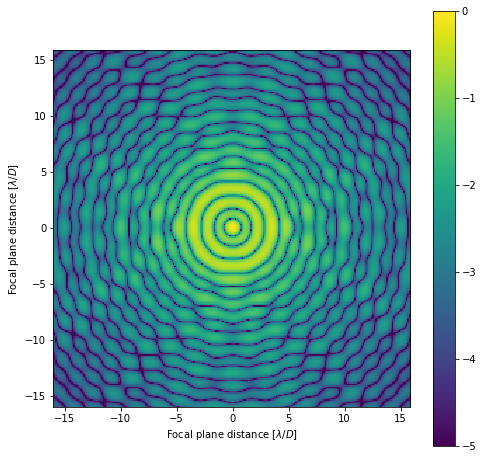

In [62]:
fig = plt.figure(figsize=(8,8))
imshow_field(np.log10(img.intensity / img.intensity.max()), vmin=-5)
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.colorbar()
plt.show()

Alright now to try to put in the apodizer

In [63]:
from gpipsfs import *

In [64]:
tst = GPI_Coronagraphic_Apodizer()

In [146]:
tst._apod_interpolator(7.7/2)

array(0.05332503)

In [147]:
from gpipsfs import *
def make_gpi_apodizer_no_sat_spots(normalized=True):
    '''Make the GPI Apodizer (w/o the diffraction grid)

    Parameters
    ----------
    normalized : boolean
        If this is True, the outer diameter will be scaled to 1. Otherwise, the
        diameter of the pupil will be 6.5 meters.

    Returns
    -------
    Field generator
    The gpi apodizer
    '''
    gpi_apodizer = GPI_Coronagraphic_Apodizer()
    
    pupil_diameter = 7.701 #m
    
    def func(grid):
        if grid.is_('cartesian'):
            if grid.is_separated:
                x,y = grid.separated_coords
#                 print(x[np.newaxis,:].shape)
                
                
                if normalized:
                    r = np.sqrt((x[np.newaxis,:]*pupil_diameter)**2+(y[:,np.newaxis]*pupil_diameter)**2)
                else:
                    r = np.sqrt((x[np.newaxis,:])**2+(y[:,np.newaxis])**2)
                print(np.max(x))
                transmission=gpi_apodizer._apod_interpolator(r).ravel()
            else:
                x,y = grid.coords
                r = np.sqrt(x**2+y**2)
                if normalized:
                    r *= (pupil_diameter)
                transmission=gpi_apodizer._apod_interpolator(r)
                
        else:
            if normalized:
                transmission = gpi_apodizer._apod_interpolator(grid.r*(pupil_diameter))
            else:
                transmission = gpi_apodizer._apod_interpolator(grid.r)
        
        return Field(transmission.astype('float'),grid)
            
    return func

### Great, now to add in the wire grid

In [151]:
from gpipsfs import *
def make_gpi_apodizer(normalized=True):
    '''Make the GPI Apodizer (w/ the diffraction grid)

    Parameters
    ----------
    normalized : boolean
        If this is True, the outer diameter will be scaled to 1. Otherwise, the
        diameter of the pupil will be 6.5 meters.

    Returns
    -------
    Field generator
    The gpi apodizer
    '''
    

    apod_parameters = (7.5, 585) #H-band apodizer parameters
    
    primary_diameter = 7.701
    magnification = primary_diameter/.009825   # meters at primary/meters at Lyot
    
    width = apod_parameters[0]*1e-6*magnification
    spacing = apod_parameters[1]*1e-6*magnification
    diag_spacing = spacing * np.sqrt(2)
    start = -primary_diameter/2
    
    if normalized:
        width /= primary_diameter
        spacing /= primary_diameter
        diag_spacing /= primary_diameter
        start /= primary_diameter
        pupil_diameter = 1.
    else:
        pupil_diameter = primary_diameter
        
    
    def func(grid):
        to_return = make_gpi_apodizer_no_sat_spots(normalized=normalized)(grid)
        nlines = 11
        
        for n in np.arange(nlines*2+1)-nlines:
            to_return *= make_spider_infinite([pupil_diameter/2+n*diag_spacing,pupil_diameter/2], 45, width)(grid)
            to_return *= make_spider_infinite([pupil_diameter/2,-pupil_diameter/2+n*diag_spacing], -45, width)(grid)
            
        return to_return
    return func

In [152]:
test_apodizer = make_gpi_apodizer()

0.4997568093385214


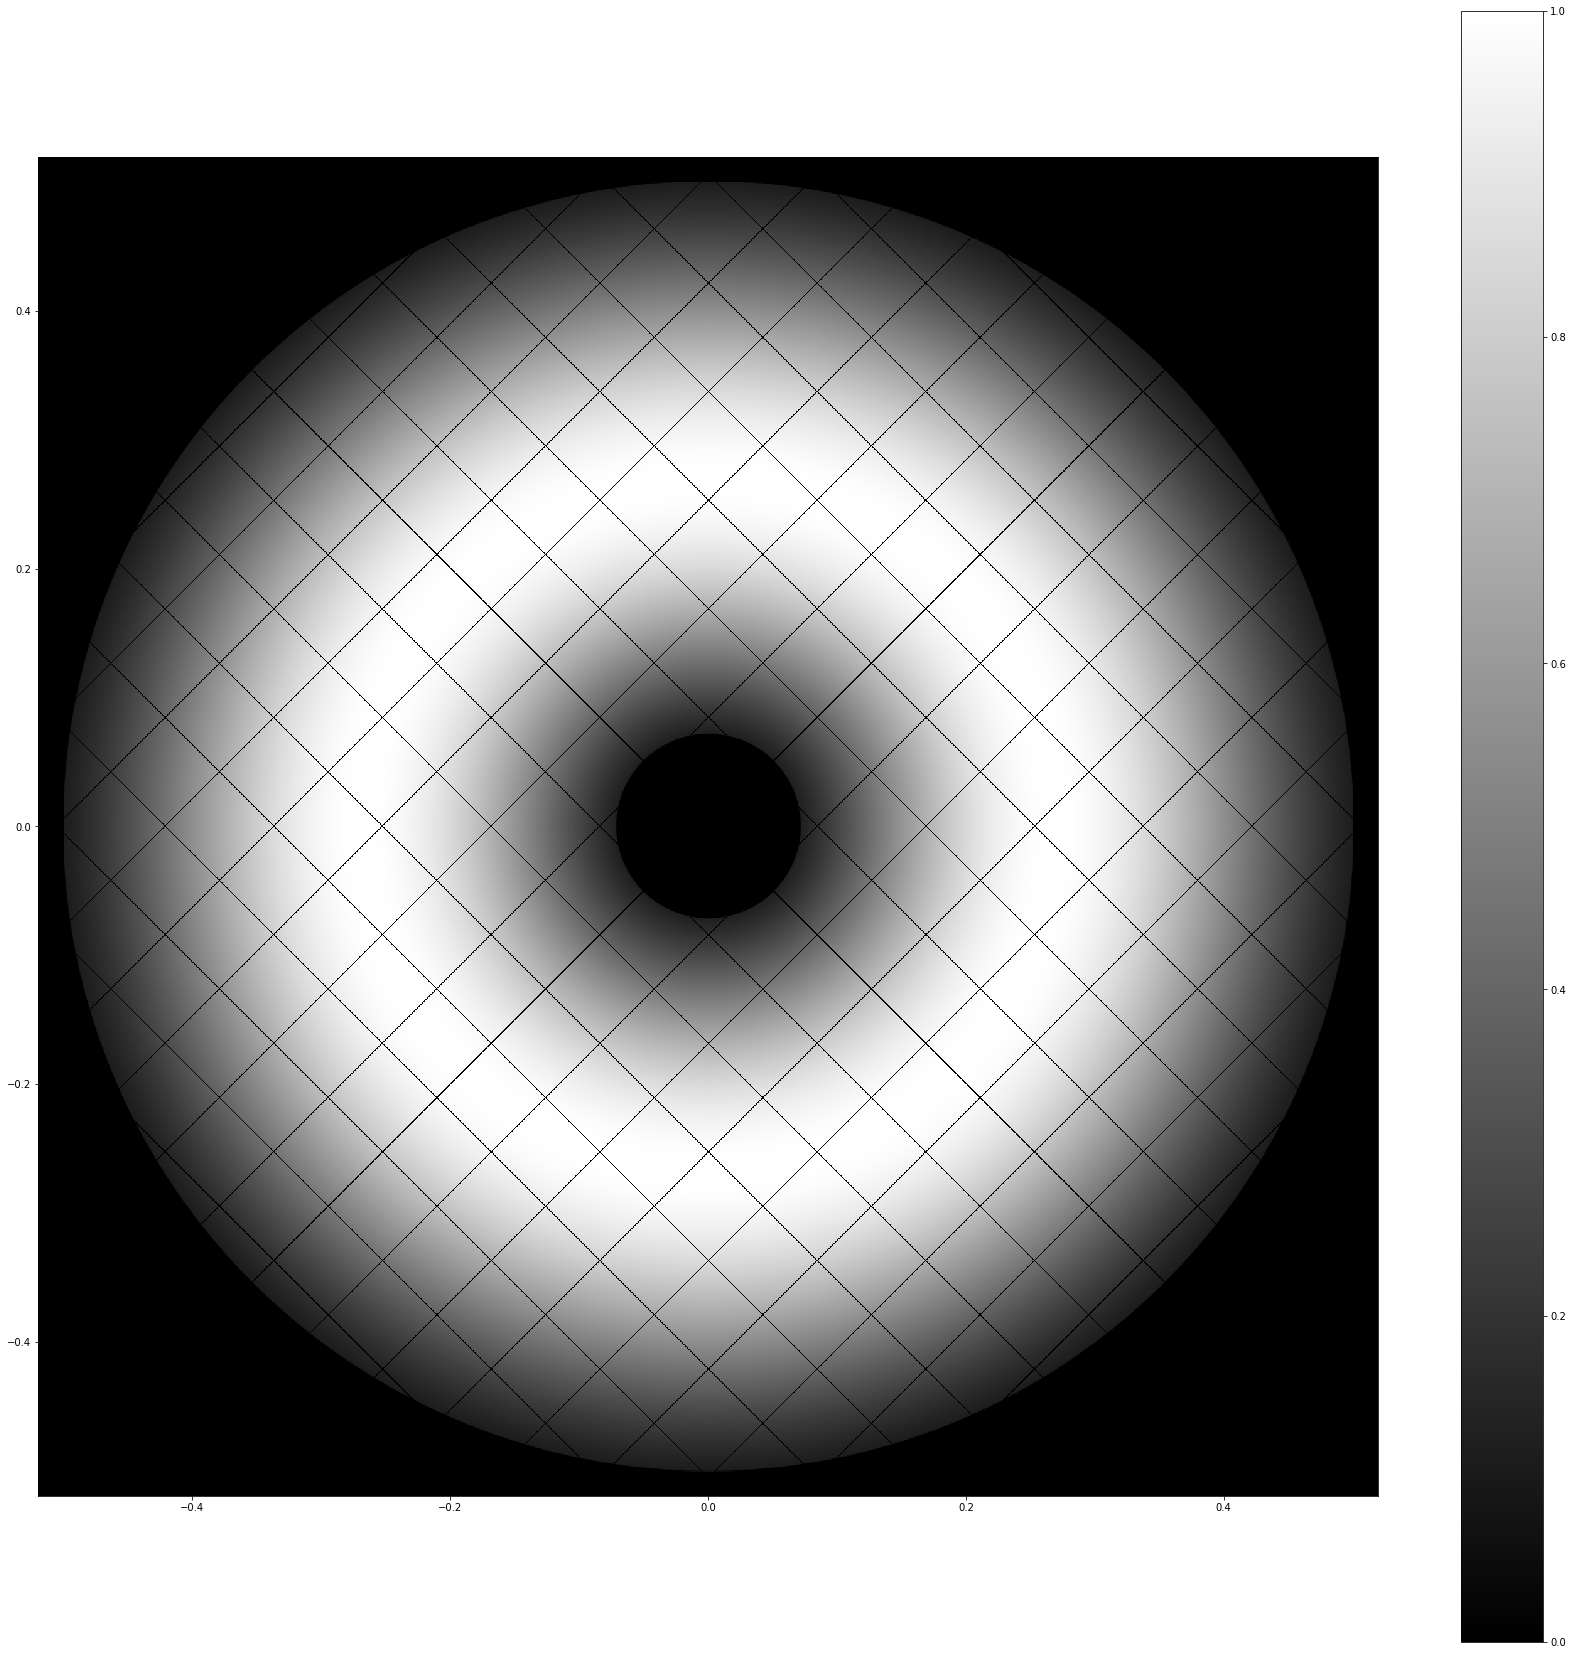

In [154]:
fig,axes = plt.subplots(1,1,figsize=(30,30))
cmap = matplotlib.cm.get_cmap('gray')
cmap.set_bad("k")
imshow_field(test_apodizer(pupil_grid),cmap=cmap,vmin=0,vmax=1)
plt.xlim(-4/7.701,4/7.701)
plt.ylim(-4/7.701,4/7.701)
plt.colorbar()
axes.set_facecolor('k')

# Ok Great, now let's go run this through again

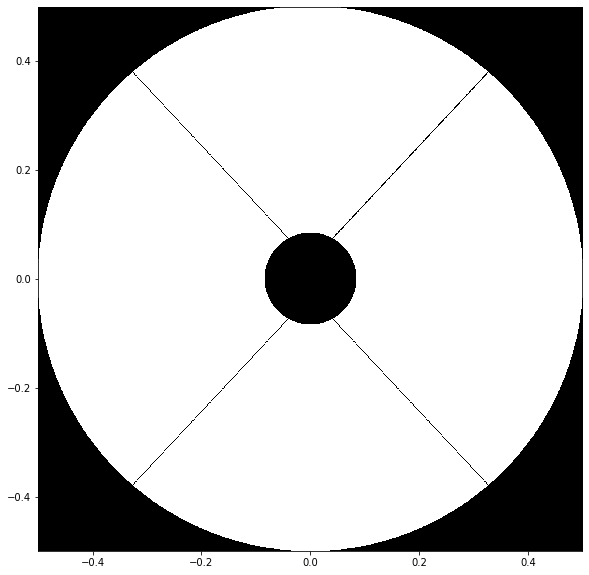

In [155]:
pupil_grid=make_pupil_grid(2056)

telescope_pupil_generator=make_geminisouth_aperture(normalized=True,with_spiders=True)
telescope_pupil = telescope_pupil_generator(pupil_grid)

plt.figure(figsize=(10,10))
im = imshow_field(telescope_pupil,cmap='gray')

In [156]:
wavefront = Wavefront(telescope_pupil)

focal_grid = make_focal_grid(q=8,num_airy=32)
prop = FraunhoferPropagator(pupil_grid,focal_grid)

gpi_apodizer = Apodizer(make_gpi_apodizer(pupil_grid))
apodized = prop(gpi_apodizer(wavefront))

0.4997568093385214


In [157]:
gpi_apodizer(wavefront)

/Users/maxwellmb/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


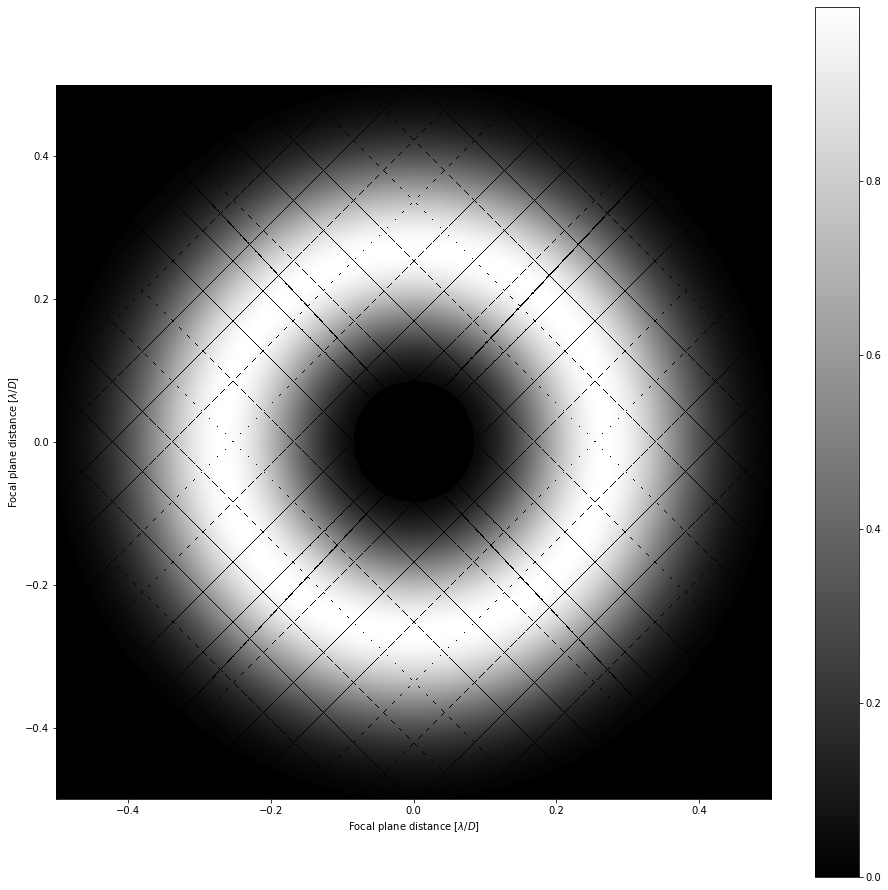

In [158]:
fig = plt.figure(figsize=(16,16))
imshow_field(np.log10(gpi_apodizer(wavefront).intensity / gpi_apodizer(wavefront).intensity.max()), 
             vmin=-5,cmap='gray')
imshow_field(gpi_apodizer(wavefront).intensity,cmap='gray')

plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.colorbar()
plt.show()

## Now to the focal plane

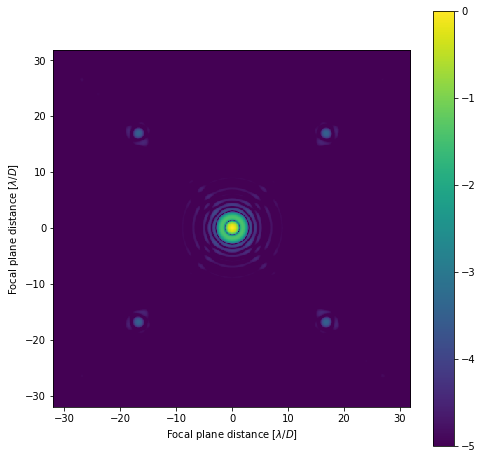

In [73]:
focal_image = prop.forward(wavefront)

fig = plt.figure(figsize=(8,8))
imshow_field(np.log10(apodized.intensity / apodized.intensity.max()), vmin=-5)
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.colorbar()
plt.show()

/Users/maxwellmb/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


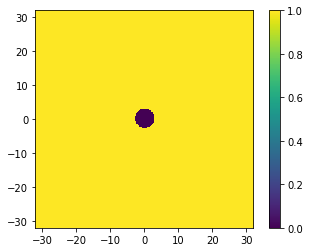

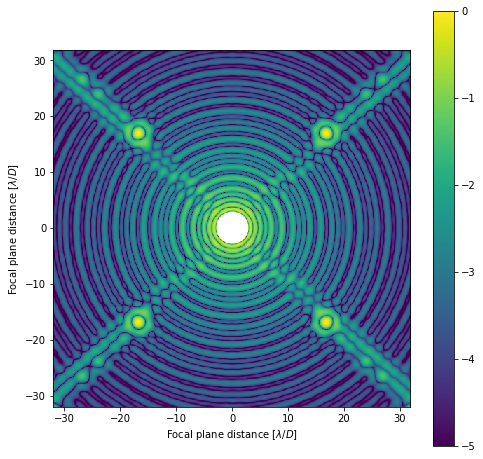

In [74]:
#The focal plane mask
fpm_field = 1-circular_aperture(5.65)(focal_grid) #Now in the the units in lambda/D
fpm = Apodizer(fpm_field)


imshow_field(fpm_field)
plt.colorbar()

post_fpm = fpm(apodized)
# post_fpm = prop(fpm(apodized))


fig = plt.figure(figsize=(8,8))
imshow_field(np.log10(post_fpm.intensity / post_fpm.intensity.max()), vmin=-5)
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.colorbar()
plt.show()

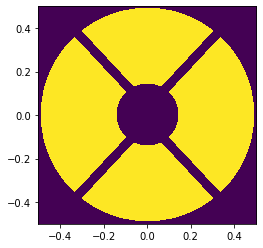

In [75]:
#The lyot stop
lyot_stop = make_gpi_lyot(normalized=True)(pupil_grid)
imshow_field(lyot_stop)

Put it into the LyotCoronagraph Structure

In [76]:
coro = LyotCoronagraph(pupil_grid,fpm_field,lyot_stop)(gpi_apodizer(wavefront))

/Users/maxwellmb/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


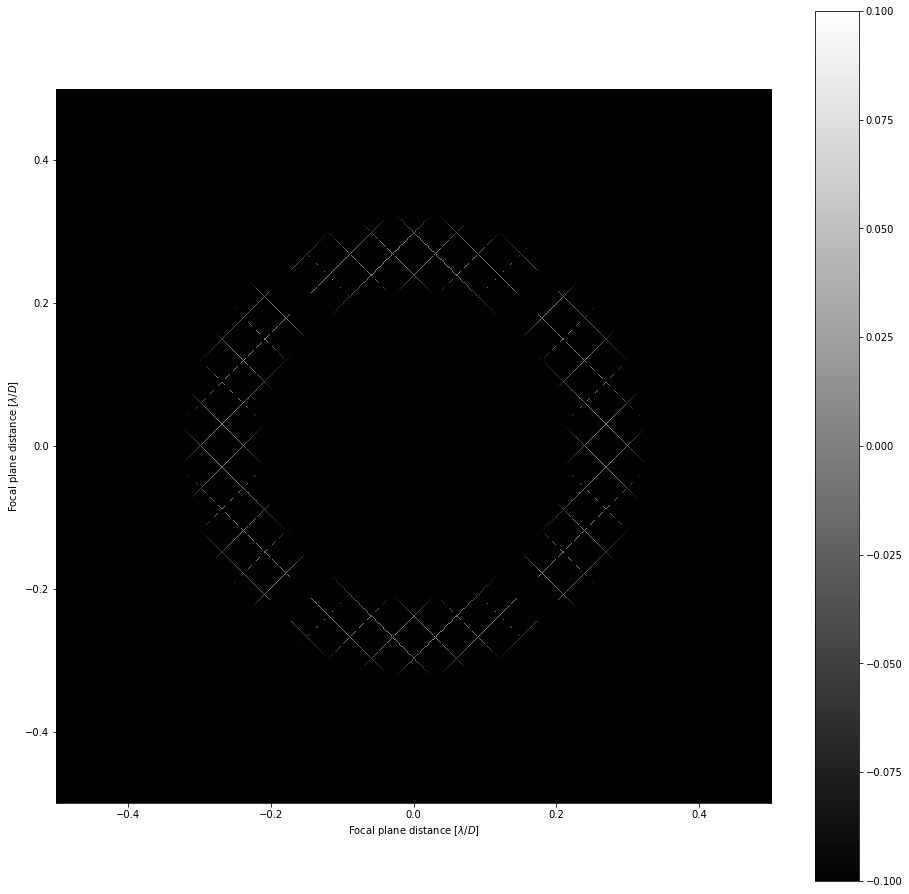

In [163]:
import matplotlib
cmap = matplotlib.cm.get_cmap("gray")
cmap.set_bad(color='k')
fig = plt.figure(figsize=(16,16))
imshow_field(np.log10(coro.intensity/np.max(coro.intensity)),cmap=cmap)
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.colorbar()
plt.show()

## Now to the focal plane

In [164]:
img = prop(coro)

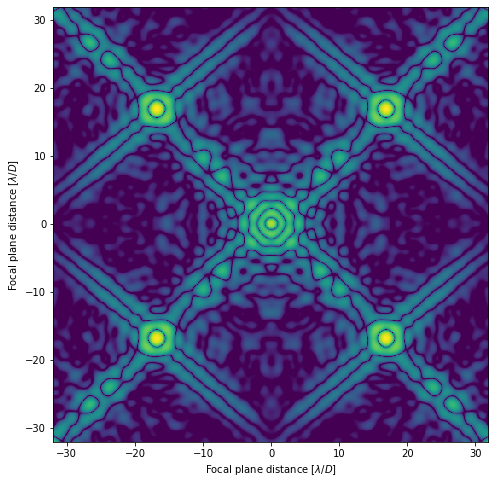

In [180]:
fig = plt.figure(figsize=(8,8))
imshow_field(np.log10(img.intensity / img.intensity.max()), vmin=-5)
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
# plt.colorbar()
plt.show()

In [177]:
np.log10(img.intensity / img.intensity.max()).shape

(262144,)